Analyzing interval durations...
Reading file: /home/wanglab/spike-analysis/Data/052725_1/pico_time_adjust.csv
Total intervals: 12390
Columns: ['pico_Interval Start', 'pico_Interval End', 'pico_Interval Duration']

Duration statistics (in milliseconds):
Min: 0.000 ms
Max: 76697.467 ms
Mean: 26.994 ms
Median: 10.000 ms

INTERVAL DURATION ANALYSIS
Duration (ms)    Count    Min (ms)    Max (ms)    Mean (ms)   Std (ms)
----------------------------------------------------------------------
    10.0        8339      8.933      18.667      10.008     0.245     (71.5%)
    25.0        2110     21.733      26.000      24.994     0.134     (18.1%)
   100.0         473     99.867     100.133      99.997     0.031     ( 4.1%)
     4.9         431      0.000       4.933       3.669     2.105     ( 3.7%)
    50.0         303     45.600      50.133      49.975     0.311     ( 2.6%)
----------------------------------------------------------------------
Total intervals shown: 11656


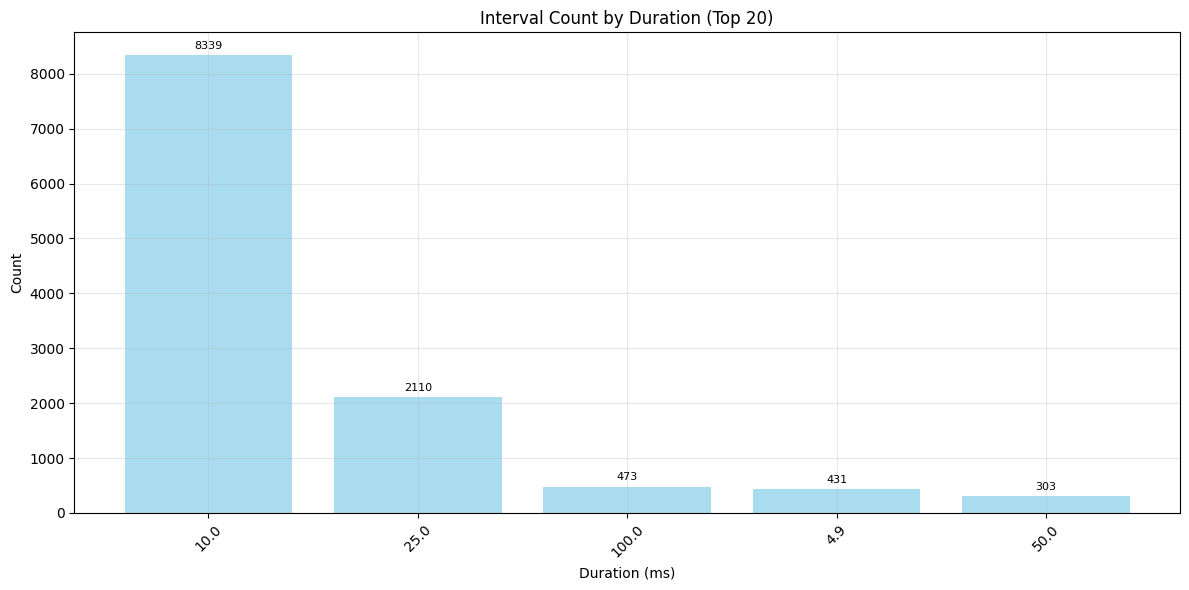


SUMMARY
Total unique duration groups: 15
Duration groups with ≥100 intervals: 5
Most common duration: 10.0 ms (8339 intervals)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os

def analyze_interval_durations(file_path, tolerance_ms=5.0):
    """
    Analyze interval durations from pico_time_adjust.csv and count occurrences.
    
    Parameters:
    - file_path: Path to the pico_time_adjust.csv file
    - tolerance_ms: Tolerance in milliseconds for grouping similar durations (increased default)
    
    Returns:
    - Dictionary with duration groups and their counts
    """
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found: {file_path}")
        return None
        
    try:
        # Read the CSV file
        print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path)
        
        # Display basic info
        print(f"Total intervals: {len(df)}")
        print(f"Columns: {list(df.columns)}")
        
        # Get duration column (convert seconds to milliseconds for easier interpretation)
        duration_col = 'pico_Interval Duration'
        if duration_col not in df.columns:
            print(f"Error: Column '{duration_col}' not found!")
            return None
            
        # Convert durations from seconds to milliseconds
        durations_ms = df[duration_col] * 1000
        
        print(f"\nDuration statistics (in milliseconds):")
        print(f"Min: {durations_ms.min():.3f} ms")
        print(f"Max: {durations_ms.max():.3f} ms")
        print(f"Mean: {durations_ms.mean():.3f} ms")
        print(f"Median: {durations_ms.median():.3f} ms")
        
        # Group durations with tolerance
        tolerance_s = tolerance_ms / 1000.0  # Convert tolerance to seconds
        duration_groups = defaultdict(list)
        
        # Sort durations to process systematically
        sorted_durations = sorted(durations_ms.values)
        processed = set()
        
        for duration_ms in sorted_durations:
            duration_s = duration_ms / 1000.0
            
            if duration_s in processed:
                continue
                
            # Find all durations within tolerance
            group_durations = df[
                (df[duration_col] >= duration_s - tolerance_s) & 
                (df[duration_col] <= duration_s + tolerance_s)
            ][duration_col]
            
            if len(group_durations) > 0:
                # Use the median duration as the group representative
                group_center_s = group_durations.median()
                group_center_ms = group_center_s * 1000
                
                duration_groups[group_center_ms] = {
                    'count': len(group_durations),
                    'min_ms': group_durations.min() * 1000,
                    'max_ms': group_durations.max() * 1000,
                    'mean_ms': group_durations.mean() * 1000,
                    'std_ms': group_durations.std() * 1000
                }
                
                # Mark these durations as processed
                for dur_s in group_durations:
                    processed.add(dur_s)
        
        return duration_groups, df
        
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

def display_duration_analysis(duration_groups, min_count=1, show_plot=True):
    """
    Display the analysis results in a formatted table and optional plot.
    
    Parameters:
    - duration_groups: Dictionary from analyze_interval_durations
    - min_count: Minimum count to display (filter rare durations)
    - show_plot: Whether to show a bar plot
    """
    
    if not duration_groups:
        return
        
    print(f"\n{'='*80}")
    print("INTERVAL DURATION ANALYSIS")
    print(f"{'='*80}")
    
    # Sort by count (descending)
    sorted_groups = sorted(duration_groups.items(), key=lambda x: x[1]['count'], reverse=True)
    
    # Filter by minimum count
    filtered_groups = [(dur, info) for dur, info in sorted_groups if info['count'] >= min_count]
    
    print(f"Duration (ms)    Count    Min (ms)    Max (ms)    Mean (ms)   Std (ms)")
    print("-" * 70)
    
    total_intervals = sum(info['count'] for _, info in filtered_groups)
    
    for duration_ms, info in filtered_groups:
        percentage = (info['count'] / total_intervals) * 100
        
        print(f"{duration_ms:8.1f}      {info['count']:6d}    "
              f"{info['min_ms']:7.3f}     {info['max_ms']:7.3f}     "
              f"{info['mean_ms']:7.3f}    {info['std_ms']:6.3f}     "
              f"({percentage:4.1f}%)")
    
    print("-" * 70)
    print(f"Total intervals shown: {total_intervals}")
    
    # Create single bar plot if requested
    if show_plot and len(filtered_groups) > 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        # Plot: Count by duration
        durations = [dur for dur, _ in filtered_groups[:20]]  # Top 20
        counts = [info['count'] for _, info in filtered_groups[:20]]
        
        bars = ax.bar(range(len(durations)), counts, alpha=0.7, color='skyblue')
        ax.set_xlabel('Duration (ms)')
        ax.set_ylabel('Count')
        ax.set_title('Interval Count by Duration (Top 20)')
        ax.set_xticks(range(len(durations)))
        ax.set_xticklabels([f'{d:.1f}' for d in durations], rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Add count labels on bars
        for i, (bar, count) in enumerate(zip(bars, counts)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                    str(count), ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
    return filtered_groups

# Set file path
file_path = "/home/wanglab/spike-analysis/Data/052725_1/pico_time_adjust.csv"

# Analyze the intervals with increased tolerance
print("Analyzing interval durations...")
result = analyze_interval_durations(file_path, tolerance_ms=5.0)

if result:
    duration_groups, df = result
    
    # Display results
    filtered_groups = display_duration_analysis(duration_groups, min_count=100, show_plot=True)
    
    # Additional summary
    print(f"\n{'='*80}")
    print("SUMMARY")
    print(f"{'='*80}")
    print(f"Total unique duration groups: {len(duration_groups)}")
    print(f"Duration groups with ≥100 intervals: {len([g for g in duration_groups.values() if g['count'] >= 100])}")
    print(f"Most common duration: {max(duration_groups.items(), key=lambda x: x[1]['count'])[0]:.1f} ms "
          f"({max(duration_groups.values(), key=lambda x: x['count'])['count']} intervals)")
else:
    print("Failed to analyze the file.")